# Multivariate Regression #

In [19]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visuals
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from config import get_tickers
from data_downloader import get_market_data
from capm_toolkit import wexp

In [20]:
tickers = get_tickers(mod="3.4")

tickers

['AAPL', 'MSFT', 'NVDA', 'WMT']

In [21]:
# Import data
data_regression = pd.DataFrame()

for ticker in tickers:
    df = get_market_data(
        ticker=ticker, 
        start_date='2010-01-01', 
        end_date='2025-01-01', 
        returns=True
    )
    
    returns = df['returns'].rename(ticker)
    
    data_regression = pd.concat([data_regression, returns], axis=1)
    
    print(f'Data Ready for {ticker}')

Data Ready for AAPL
Data Ready for MSFT
Data Ready for NVDA
Data Ready for WMT


In [22]:
data_regression

,AAPL,MSFT,NVDA,WMT
2010-01-05 00:00:00,0.001728,0.000323,0.014497,-0.010007
2010-01-06 00:00:00,-0.016034,-0.006156,0.006376,-0.002238
2010-01-07 00:00:00,-0.001851,-0.010454,-0.019792,0.000560
2010-01-08 00:00:00,0.006626,0.006873,0.002159,-0.005050
2010-01-11 00:00:00,-0.008861,-0.012802,-0.014115,0.016366
...,...,...,...,...
2024-12-24 00:00:00,0.011413,0.009330,0.003930,0.025462
2024-12-26 00:00:00,0.003171,-0.002781,-0.002070,0.001186
2024-12-27 00:00:00,-0.013331,-0.017453,-0.021088,-0.012253
2024-12-30 00:00:00,-0.013352,-0.013328,0.003497,-0.011963


In [23]:
# X Variables
benchmark = pd.read_csv("../additional_data/sp500.csv")
benchmark.set_index("date", inplace=True)
benchmark.index = pd.to_datetime(benchmark.index)

benchmark

,sp_500
date,
2010-01-05,0.003111
2010-01-06,0.000545
2010-01-07,0.003993
2010-01-08,0.002878
2010-01-11,0.001745
...,...
2024-12-24,0.010982
2024-12-26,-0.000406
2024-12-27,-0.011117


In [24]:
# Y Matrix
Y_Matrix = data_regression

# X Matrix
Information_Matrix = sm.add_constant(benchmark['sp_500'])

In [25]:
def SimpleLinearRegressionCoefficients(
    y_matrix: pd.DataFrame, 
    information_matrix:pd.DataFrame
):
    # Check if both arrays have the same rows
    if information_matrix.shape[0] != y_matrix.shape[0]:
        raise ValueError("The rows are not coincident.")
    
    # Set the components
    X = information_matrix
    Y = y_matrix
    
    # Calculate the interaction arrays
    X_T = X.T
    XTX_inv = np.linalg.inv(X_T.dot(X))
    XTY = X_T.dot(Y)
    
    # Coefficients
    coef = XTX_inv.dot(XTY)
    
    # Fitted values and residuals
    fitted = X.dot(coef)
    residuals = Y.to_numpy() - fitted
    
    # Sigmas
    stds = residuals.std(axis=0, ddof=1).to_numpy()
    
    # Output Series
    alphas = pd.Series(coef[0], index=Y.columns, name='alpha')
    betas = pd.Series(coef[1], index=Y.columns, name='beta')
    sigmas = pd.Series(stds, index=Y.columns, name='sigma')
    
    return alphas, betas, sigmas


In [26]:
# Calculate the betas
alphas, betas, sigmas = SimpleLinearRegressionCoefficients(Y_Matrix, Information_Matrix)

coefficients = pd.DataFrame(
    {'alpha': alphas, 'beta': betas, 'sigma': sigmas},
)

coefficients

,alpha,beta,sigma
AAPL,0.000488,1.104945,0.012789
MSFT,0.000278,1.120878,0.010518
NVDA,0.000809,1.642658,0.022087
WMT,0.000297,0.492494,0.010830


In [27]:
# Computationally, this method is more efficient, but the results are the same:
model = sm.OLS(Y_Matrix['WMT'], Information_Matrix)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    WMT   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     924.6
Date:                Sun, 20 Jul 2025   Prob (F-statistic):          8.11e-182
Time:                        19:13:32   Log-Likelihood:                 11721.
No. Observations:                3773   AIC:                        -2.344e+04
Df Residuals:                    3771   BIC:                        -2.343e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.684      0.0

In [28]:
# Now how can we make this rolling
def RollingOLSCoefficients(
    y_matrix: pd.DataFrame, 
    x_matrix: pd.Series,
    window: int = 252
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    # Lists to store results
    alphas_list = []
    betas_list = []
    sigmas_list = []
    dates = []

    # Rolling window
    for i in range(window, len(y_matrix)):
        X_window = x_matrix[i - window:i]  # (252, 2)
        Y_window = y_matrix.iloc[i - window:i]  # (252, n_assets)

        # Calculate the coefficients
        try:
            alpha, beta, sigma = SimpleLinearRegressionCoefficients(
                Y_window,
                pd.DataFrame(X_window, index=Y_window.index)
            )
            alphas_list.append(alpha)
            betas_list.append(beta)
            sigmas_list.append(sigma)
            dates.append(y_matrix.index[i])

        except np.linalg.LinAlgError:
            # Singular matrix, skip this window
            continue

    # Create DataFrames
    alphas_df = pd.DataFrame(alphas_list, index=dates)
    betas_df = pd.DataFrame(betas_list, index=dates)
    sigmas_df = pd.DataFrame(sigmas_list, index=dates)

    return alphas_df, betas_df, sigmas_df

In [29]:
alphas_series, betas_series, sigmas_series = RollingOLSCoefficients(
    Y_Matrix, 
    Information_Matrix,
)

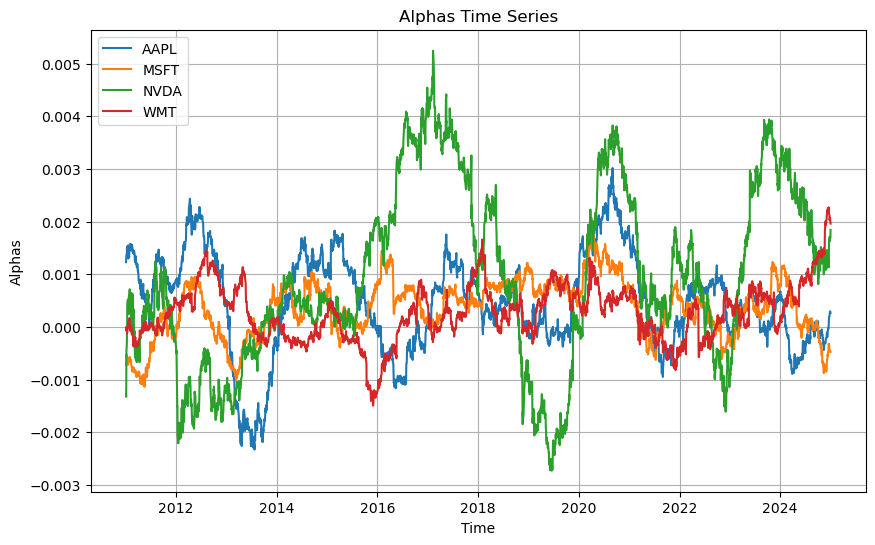

In [30]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(alphas_series, label=alphas_series.columns, alpha=1)

# Config
plt.title('Alphas Time Series')
plt.xlabel('Time')
plt.ylabel('Alphas')
plt.legend()

# Show
plt.grid(True)
plt.show()

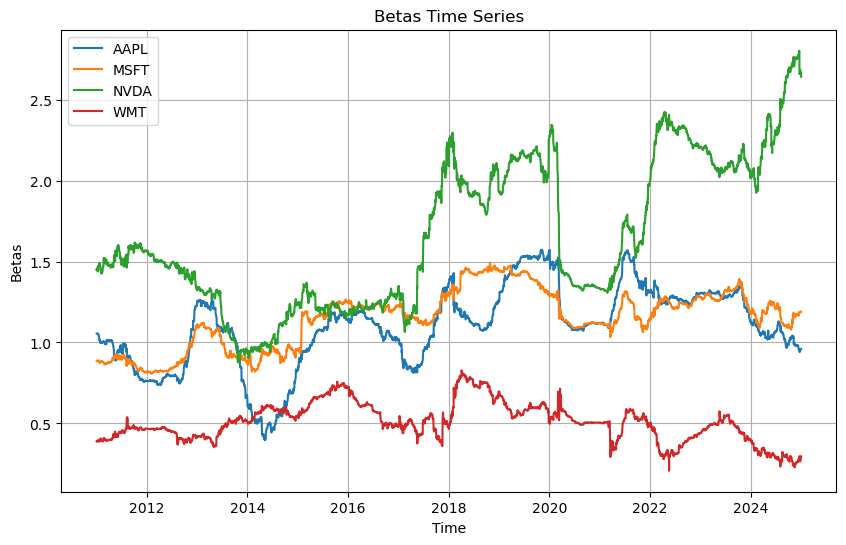

In [31]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(betas_series, label=betas_series.columns, alpha=1)

# Config
plt.title('Betas Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.grid(True)
plt.show()

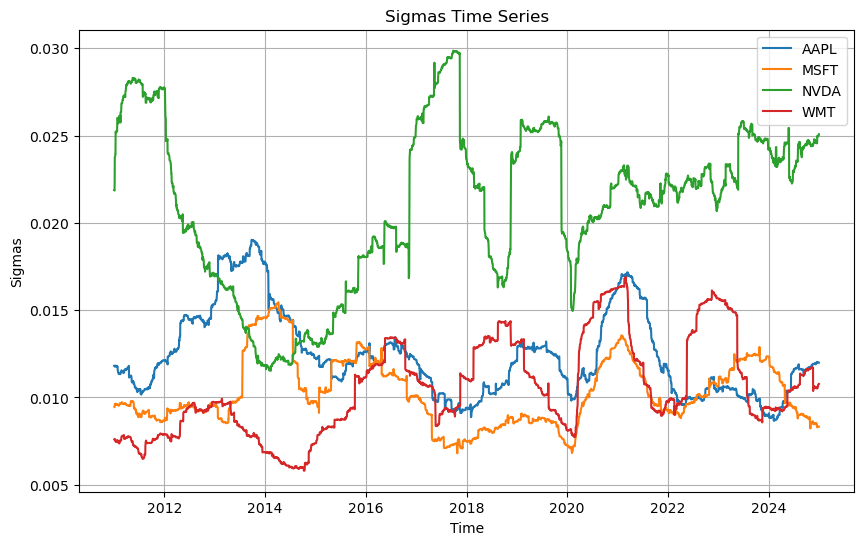

In [32]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(sigmas_series, label=sigmas_series.columns, alpha=1)

# Config
plt.title('Sigmas Time Series')
plt.xlabel('Time')
plt.ylabel('Sigmas')
plt.legend()

# Show
plt.grid(True)
plt.show()

### Adding Weights to the Regression (WLS) ###

Weighted Least Squares Regression introduces the weighting of observations in our regression to give preference to those with certain characteristics we value most. In the case of time series regressions, we often want to introduce time-based weights, giving priority to observations closer to the present.

The solution of the optimization including weights is:

$$
\beta_{WLS} = \left( X^{\top}WX\right)^{-1} \left( X^{\top}WY \right)
$$

In [33]:
# Define the functions
def WeightedLinearRegressionCoefficients(
    y_matrix: pd.DataFrame, 
    information_matrix:pd.DataFrame,
    weights,
):
    # Check if both arrays have the same rows
    if information_matrix.shape[0] != y_matrix.shape[0]:
        raise ValueError("The rows are not coincident.")
    
    # Set the components
    X = information_matrix
    Y = y_matrix
    W = np.diag(weights)
    
    # Weighted Arrays
    Weighted_X = W.dot(X)
    Weighted_Y = W.dot(Y)
    
    # Calculate the interaction arrays
    X_T = X.transpose()
    X_Weighted_Var = X_T.dot(Weighted_X)
    X_Y_Weighted_Covar = X_T.dot(Weighted_Y)
    X_Weighted_Var_Inv = np.linalg.inv(X_Weighted_Var)
    
    # Coefficients
    coef = X_Weighted_Var_Inv.dot(X_Y_Weighted_Covar)
    
    # Fitted values and residuals
    fitted = X.dot(coef)
    residuals = Y.to_numpy() - fitted
    
    # Sigmas
    stds = residuals.std(axis=0, ddof=1).to_numpy()
    
    # Output Series
    alphas = pd.Series(coef[0], index=Y.columns, name='alpha')
    betas = pd.Series(coef[1], index=Y.columns, name='beta')
    sigmas = pd.Series(stds, index=Y.columns, name='sigma')
    
    return alphas, betas, sigmas

In [34]:
# Now the Rolling
def RollingWLSCoefficients(
    y_matrix: pd.DataFrame, 
    x_matrix: pd.Series,
    window: int = 252
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    # Lists to store results
    alphas_list = []
    betas_list = []
    sigmas_list = []
    dates = []

    # Rolling window
    for i in range(window, len(y_matrix)):
        X_window = x_matrix[i - window:i]  # (252, 2)
        Y_window = y_matrix.iloc[i - window:i]  # (252, n_assets)
        
        # Time-Weights
        weights = 252 * wexp(252, 126)

        # Calculate the coefficients
        try:
            # Calculate the Coefficients
            alpha, beta, sigma = WeightedLinearRegressionCoefficients(
                Y_window,
                pd.DataFrame(X_window, index=Y_window.index),
                weights
            )
            
            # Store
            alphas_list.append(alpha)
            betas_list.append(beta)
            sigmas_list.append(sigma)
            dates.append(y_matrix.index[i])

        except np.linalg.LinAlgError:
            # Singular matrix, skip this window
            continue

    # Create DataFrames
    alphas_df = pd.DataFrame(alphas_list, index=dates)
    betas_df = pd.DataFrame(betas_list, index=dates)
    sigmas_df = pd.DataFrame(sigmas_list, index=dates)

    return alphas_df, betas_df, sigmas_df

In [35]:
alphas_w_series, betas_w_series, sigmas_w_series = RollingWLSCoefficients(
    Y_Matrix,
    Information_Matrix,
)

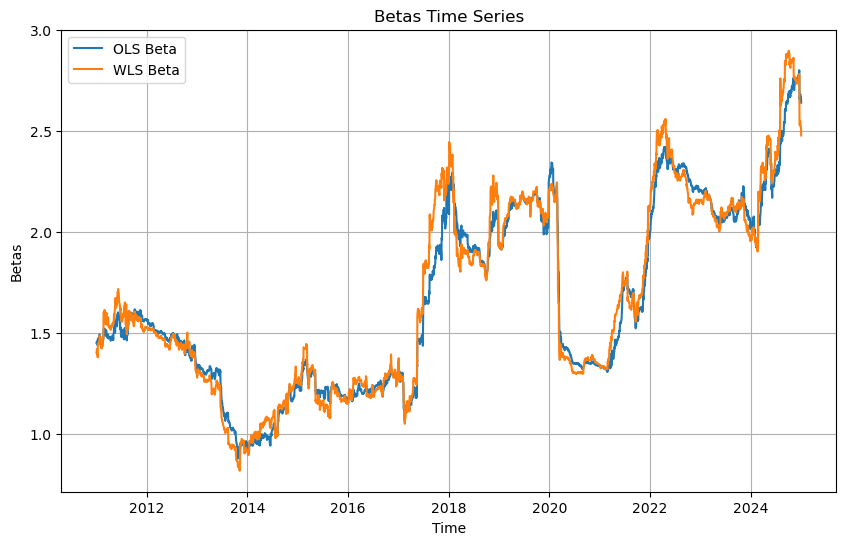

In [36]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(betas_series['NVDA'], label='OLS Beta', alpha=1)
plt.plot(betas_w_series['NVDA'], label='WLS Beta', alpha=1)

# Config
plt.title('Betas Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.grid(True)
plt.show()